# **Spotify Trending Song Prediction**

# Part 1: Introduction

For our project, we aimed to create a predictive model to determine the viral potential of songs based on a comprehensive analysis of song statistics. To achieve this, we utilized two primary datasets from Spotify. The first dataset, `tracks_df`, contains detailed information on over 1.2 million songs, including their energy index, danceability, liveness, tempo, and other musical features. The second dataset, `charts_df`, contains ingormation on the performance of songs across various Spotify charts, detailing their presence and duration within these charts throughout different years.

By analyzing these datasets, we developed a robust predictive model that can forecast the likelihood of a song going viral. This was achieved by examining both the intrinsic qualities of the songs and their historical performance on Spotify charts. Each section of our notebook is carefully annotated to explain the rationale behind our analysis, the methodologies employed, and the insights derived from our findings.

We are excited to share our model and findings and hope it provides valuable insights into a topic all members of our team find fascinating

# Part 2: Data Loading

For this step, we sought to import the relevant libraries for all stages of our report (pre-processing, exploratory data analysis, and model selection). These imports primarily span fundamental libraries such as pandas, matplotlib, numpy, and sklearn along with the necessary imports for pyspark that we are using in our project

In [ ]:
!apt install libkrb5-dev
!pip install sparkmagic

## 2.1: Importing Libraries and Spark Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import re
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%reload_ext sparkmagic.magics

In [ ]:
%load_ext sparkmagic.magics

The sparkmagic.magics extension is already loaded. To reload it, use:
  %reload_ext sparkmagic.magics


In [ ]:
# To create the AWS Cluster, the YAML file is at https://545projectresources.s3.amazonaws.com/emr-course.yml

%spark add -s spark_session -l python -u http://ec2-34-229-190-62.compute-1.amazonaws.com/ -a cis545-livy -p password -t Basic_Access

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
9,application_1714310888803_0010,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


## 2.2 Loading Charts and Tracks Data

Given the size of our dataset, we decided to upload and use the data on a spark cluster in order to have good processing for the large amount of data that we have

In [ ]:
%%spark

from pyspark.sql.types import *

#TODO: Finish defining the brewery_data.csv schema using the given column names

tracks_schema = StructType([
    StructField("id", StringType(), True),
    StructField("name", StringType(), True),
    StructField("album", StringType(), True),
    StructField("album_id", StringType(), True),
    StructField("artists", StringType(), True),
    StructField("artist_ids", StringType(), True),
    StructField("track_number", IntegerType(), True),
    StructField("disc_number", IntegerType(), True),
    StructField("explicit", BooleanType(), True),
    StructField("danceability", FloatType(), True),
    StructField("energy", FloatType(), True),
    StructField("key", IntegerType(), True),
    StructField("loudness", FloatType(), True),
    StructField("mode", IntegerType(), True),
    StructField("speechiness", FloatType(), True),
    StructField("acousticness", FloatType(), True),
    StructField("instrumentalness", FloatType(), True),
    StructField("liveness", FloatType(), True),
    StructField("valence", FloatType(), True),
    StructField("tempo", FloatType(), True),
    StructField("duration_ms", IntegerType(), True),
    StructField("time_signature", FloatType(), True),
    StructField("year", IntegerType(), True),
    StructField("release_date", StringType(), True)
])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
tracks_raw_df = pd.read_csv("/content/drive/MyDrive/Big Data Project/tracks_features.csv")

In [ ]:
%%spark

from pyspark import SparkFiles
review_url = "https://545projectresources.s3.amazonaws.com/tracks_features.csv"
sc.addFile(review_url)
path  = SparkFiles.get('download')
tracks_raw_sdf = spark.read.csv('file://'+SparkFiles.get('tracks_features.csv'),header=True,schema = tracks_schema,quote='\"',escape='\"')


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark
tracks_raw_sdf.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|year|release_date|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|7lmeHLHBe4nmXzuXc...|             Testify|The Battle Of Los...|

In [ ]:
%%spark

from pyspark.sql.types import *

#TODO: Finish defining the brewery_data.csv schema using the given column names

charts_raw_schema = StructType([
    StructField("title", StringType(), True),
    StructField("rank", IntegerType(), True),
    StructField("date", StringType(), True),
    StructField("artist", StringType(), True),
    StructField("url", StringType(), True),
    StructField("region", StringType(), True),
    StructField("chart", StringType(), True),
    StructField("trend", StringType(), True),
    StructField("streams", FloatType(), True)
])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# charts_raw_df = pd.read_csv("/content/drive/MyDrive/Big Data Project/charts.csv")

In [ ]:
%%spark
# tracks_raw_df = pd.read_csv("/content/drive/MyDrive/Big Data Project/tracks_features.csv")

from pyspark import SparkFiles
review_url = "https://545projectresources.s3.amazonaws.com/charts.csv"
sc.addFile(review_url)
path  = SparkFiles.get('download')
charts_raw_sdf = spark.read.csv('file://'+SparkFiles.get('charts.csv'),header=True,schema = charts_raw_schema,quote='\"',escape='\"')


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark
# Let's print out the first few rows to see how the data looks like in tabular form
charts_raw_sdf.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+--------+
|               title|rank|      date|              artist|                 url|   region| chart|        trend| streams|
+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+--------+
|Chantaje (feat. M...|   1|2017-01-01|             Shakira|https://open.spot...|Argentina|top200|SAME_POSITION|253019.0|
|Vente Pa' Ca (fea...|   2|2017-01-01|        Ricky Martin|https://open.spot...|Argentina|top200|      MOVE_UP|223988.0|
|Reggaetón Lento (...|   3|2017-01-01|                CNCO|https://open.spot...|Argentina|top200|    MOVE_DOWN|210943.0|
|              Safari|   4|2017-01-01|J Balvin, Pharrel...|https://open.spot...|Argentina|top200|SAME_POSITION|173865.0|
|         Shaky Shaky|   5|2017-01-01|        Daddy Yankee|https://open.spot...|Argentina|top200|      MOVE_UP|153956.0|
+--------------------+----+-----

# Part 3: Exploratory Data Analysis

Our project focuses on the dynamic and often elusive task of predicting music trends. Specifically, our aim is to analyze various characteristics of songs to forecast their likelihood of becoming popular and making it to the trending charts. We hypothesize that certain song attributes, such as energy, danceability, and tempo, significantly influence their popularity.

To uncover these relationships and validate our hypotheses, we are conducting an exploratory data analysis (EDA) on our datasets. This EDA involves a thorough examination of the data across different columns, employing visualizations to uncover compelling insights and trends. By doing so, we hope to identify key predictors of song popularity that will feed into our predictive model, ultimately enabling us to forecast which songs are likely to go viral.

## 3.1: Checking out the Schema and ER Diagram

In [ ]:
%%spark
tracks_raw_sdf.printSchema()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: integer (nullable = true)
 |-- disc_number: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- time_signature: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- release_date: string (nullable = true)

In [ ]:
%%spark
charts_raw_sdf.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- title: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- trend: string (nullable = true)
 |-- streams: float (nullable = true)

## ER Diagram of the Datasets:

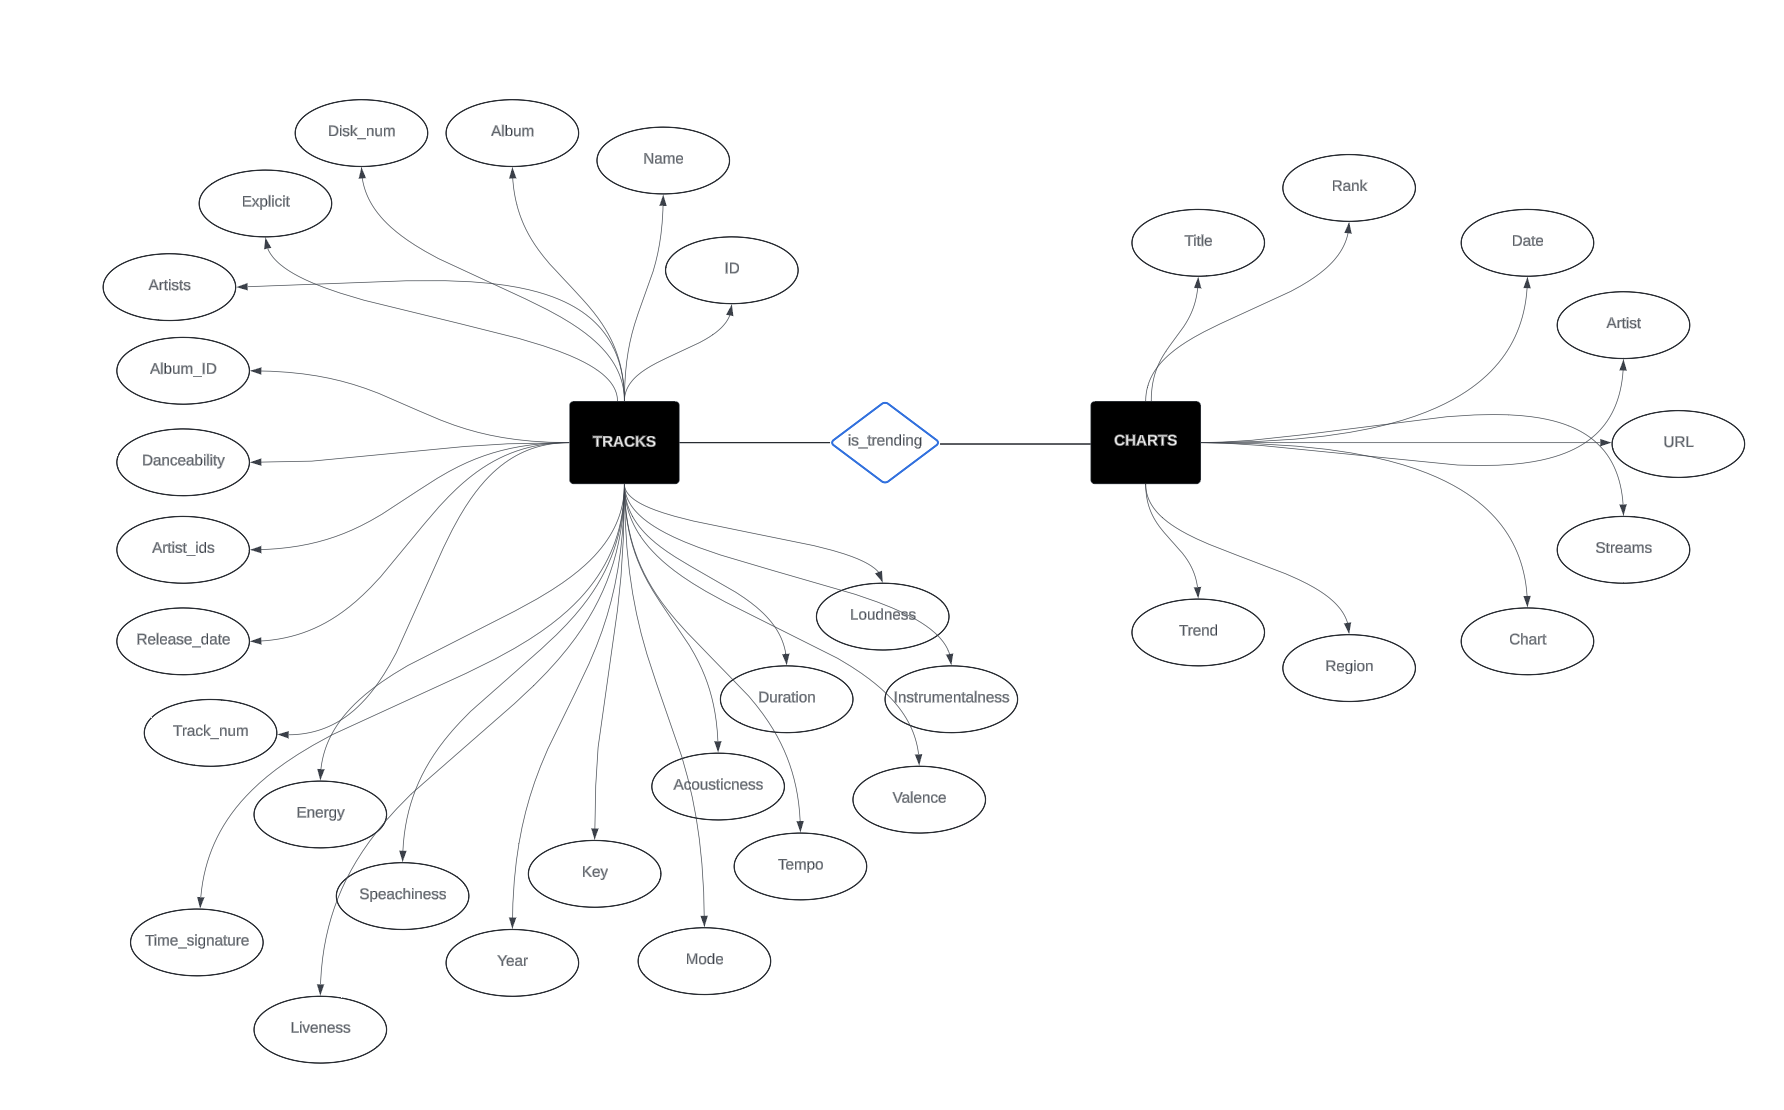

## 3.2: Identifying Critical Variables using Correlation Plots

**Correlation Analysis**

To understand the relationships between various song characteristics in our dataset, we employ a correlation plot. This visual tool is crucial for identifying how different variables are interlinked, which helps us discern potential predictors for song popularity.

By plotting the correlation matrix, we visually examine the strength and direction of relationships between variables such as energy, danceability, tempo, and others. This analysis is not only instrumental in validating our hypotheses about which features might influence a song's success but also highlights any multicollinearity that could affect the performance of our predictive model.

This step is foundational for our exploratory data analysis, as it provides valuable insights into the structure of the data, guiding our subsequent analytical efforts.

In [ ]:
%%spark

numerical_cols_sdf = tracks_raw_sdf.select([col for col, dtype in tracks_raw_sdf.dtypes if dtype in ['int', 'double', 'float']])

numerical_cols_df = numerical_cols_sdf.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

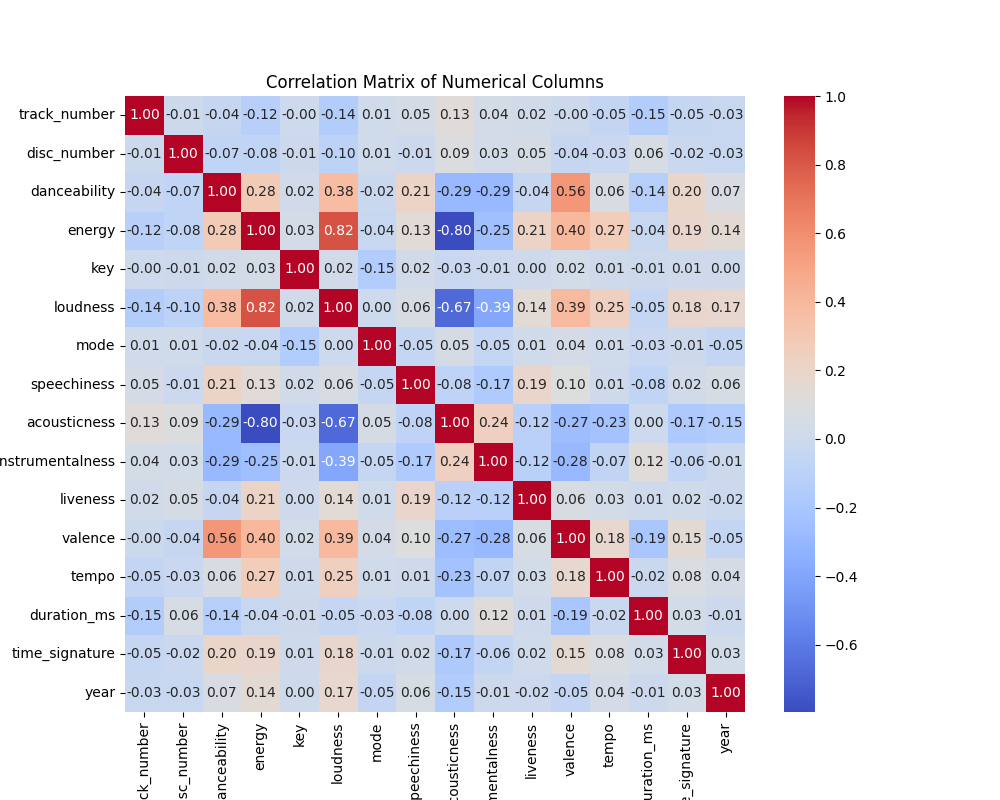

In [ ]:
%%spark

import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = numerical_cols_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

%matplot plt

This correlation matrix is a heat map that illustrates the strength of relationships between numerical columns in our dataset. Some important inferences are:

1. **Danceability and Valence**: There is a moderately strong positive correlation (0.56) between danceability and valence. This suggests that songs perceived as more joyful or positive (high valence) tend to be more danceable.

2. **Energy and Loudness**: A very strong positive correlation (0.82) between energy and loudness indicates that louder tracks are typically associated with more energetic songs.

3. **Acousticness**: There are significant negative correlations between acousticness and several variables such as energy (-0.80), loudness (-0.67), and danceability (-0.29), indicating that songs with higher acoustic features tend to be less loud, less energetic, and less suitable for dancing.

4. **Instrumentalness**: Instrumentalness appears to have a notable negative correlation with speechiness (-0.39), suggesting that tracks with more instrumental content tend to have fewer vocals.

5. **No Strong Correlation with Year**: The year doesn't show a strong correlation with any other features, which could mean that these attributes have remained relatively stable over the timeframe of the dataset or that the year alone is not a strong predictor for these song characteristics.

It’s important to note that correlation does not imply causation, and these relationships might be influenced by other underlying factors not captured by the dataset. However, these insights can guide further analysis and feature selection for predictive modeling.

In [ ]:
%%spark
import numpy as np

mask = np.abs(correlation_matrix) > 0.2
mask = mask['energy']
critical_variables_for_energy = list(mask[mask == True].index)
critical_variables_for_energy.remove('energy')
print("The variables with high correlation to energy are: ",critical_variables_for_energy)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The variables with high correlation to energy are:  ['danceability', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

## 3.3: Histogram Plots to understand variable distribution

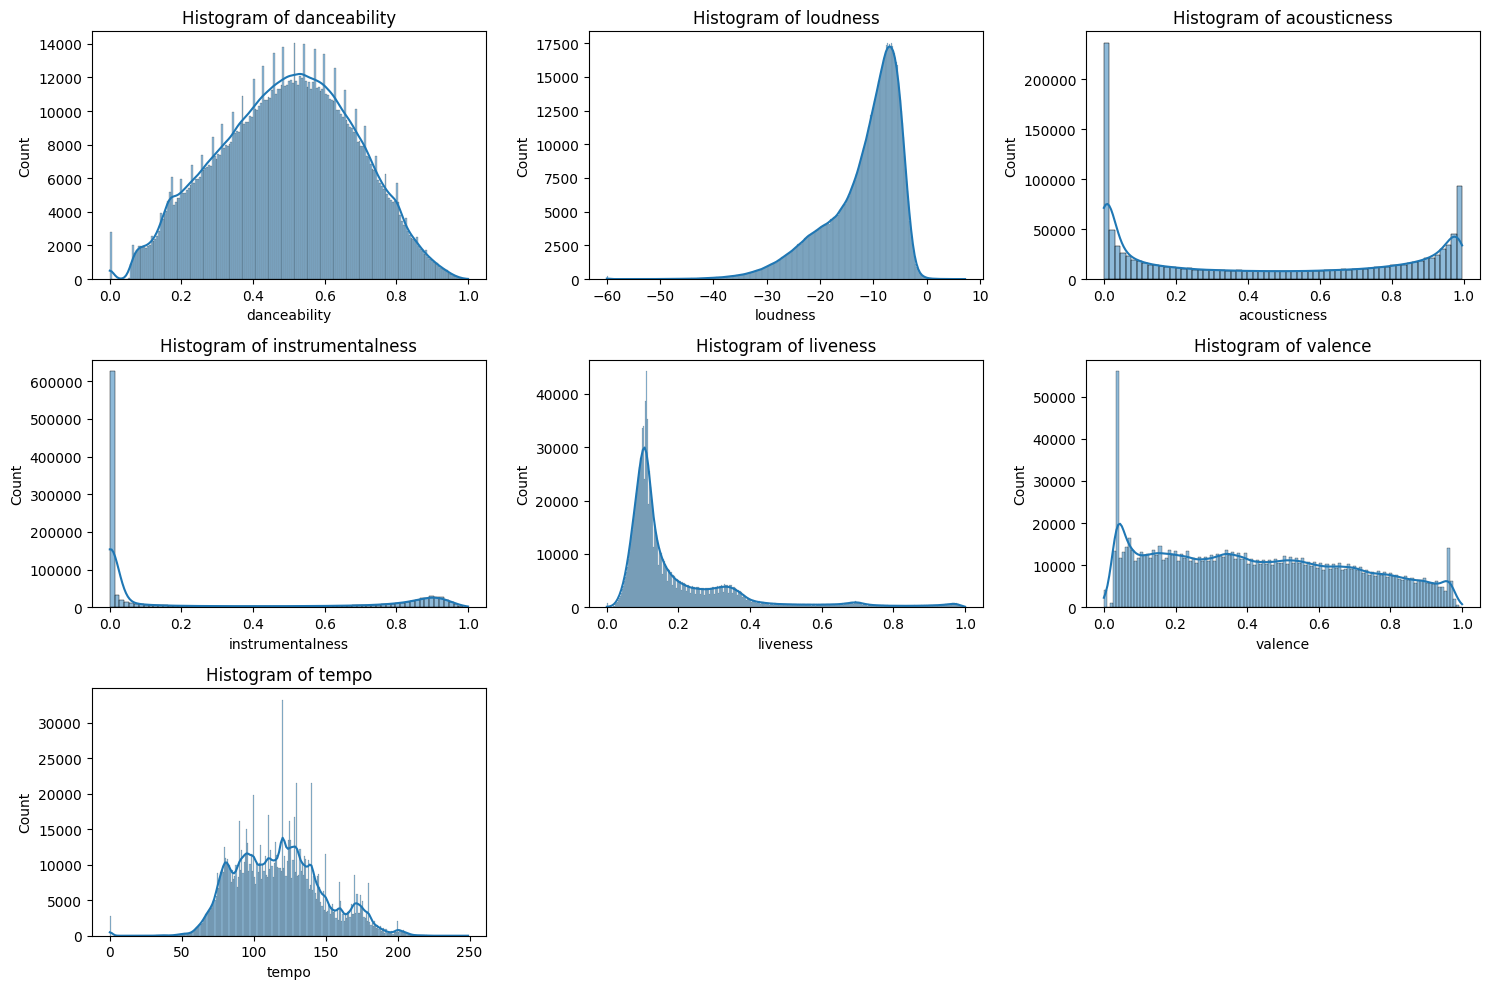

In [ ]:
variables = ['danceability', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
plt.figure(figsize=(15, 10))

for i, variable in enumerate(variables):
    plt.subplot(3, 3, i+1)
    sns.histplot(tracks_raw_df[variable], kde=True)
    plt.title(f'Histogram of {variable}')
plt.tight_layout()
plt.show()

Inferences:

1. Energy: The distribution is fairly uniform indicating that we have songs with a fair distribution.
2. Danceability: The distribution is bell-shaped, indicating that most songs have a moderate level of danceability with fewer songs at the low and high ends.
3. Loudness: This feature shows a left-skewed distribution with a peak at the higher end of the loudness scale, suggesting most songs are relatively loud, with few very quiet tracks.
4. Acousticness: The distribution is highly right-skewed, with most songs having low acousticness, indicating that fewer songs in the dataset are purely acoustic.
5. Instrumentalness: Similar to acousticness, this feature is also right-skewed. The majority of songs have very low instrumentalness, which implies that most tracks have vocal content.
6. Liveness: The distribution is right-skewed, suggesting that most songs have a lower level of liveness, indicating studio recordings rather than live performances.
7. Valence: The distribution is quite uniform with a slight skew towards the lower end, suggesting a wide range of emotion in the music, but with a slight preference for songs with lower valence, or less positivity/happiness.
8. Tempo: The distribution shows that most songs have a tempo within a moderate range, with fewer songs having very low or very high tempos. There are some notable spikes, possibly indicating common tempos for certain genres or beats per minute (BPM) that are typical in popular music.

## 3.4: Understanding Unique values

We also wish to see the amount of variation in our data in each column and for the same we want to see the number of unique values

In [ ]:
# Count unique values in each column
unique_counts = tracks_raw_df.nunique()
print(unique_counts)

id                  1204025
name                 850944
album                106162
album_id             118382
artists              165365
artist_ids           166423
track_number             50
disc_number              13
explicit                  2
danceability           1362
energy                 3441
key                      12
loudness              39805
mode                      2
speechiness            1653
acousticness           5398
instrumentalness       5402
liveness               1799
valence                1884
tempo                140472
duration_ms          210013
time_signature            5
year                    101
release_date          10566
dtype: int64


* This is the unique value counts for various attributes in our song dataset. The `id`, `name`, `artists`, and `tempo` fields have a high number of unique entries, which suggests a wide variety of songs, artists, and tempos within the dataset.
* In contrast, fields like `mode`, `explicit`, and `time_signature` have very few unique values, indicating that these characteristics are much less varied across the dataset.
* For instance, the `mode` with just 2 unique values likely represents a binary feature, possibly major or minor.
* The `explicit` field also has 2 unique values, which typically would indicate whether a song is explicit or not.

These insights are important for understanding the diversity and distribution of characteristics in the dataset, which could impact the performance of the predictive model.

## 3.5: Visualising amount of songs in each year and by different artists

Next, we want to understand the variation in the number of songs for every artist and accross years in our dataset.

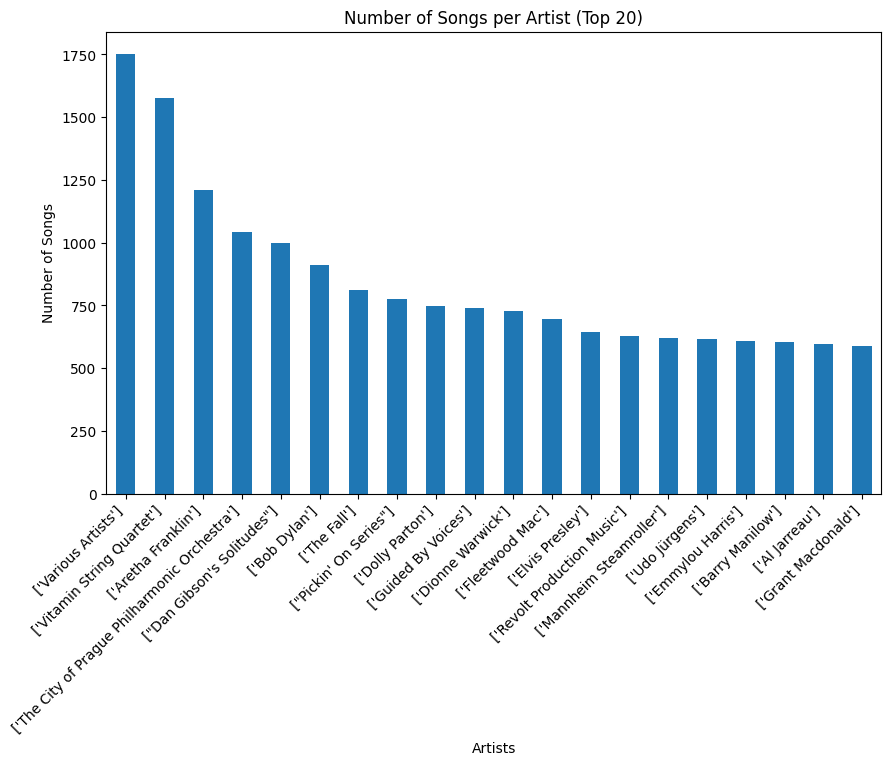

In [ ]:
songs_per_artist = tracks_raw_df['artists'].value_counts()
plt.figure(figsize=(10, 6))
songs_per_artist.head(20).plot(kind='bar')
plt.title('Number of Songs per Artist (Top 20)')
plt.xlabel('Artists')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45, ha='right')
plt.show()

Inference: This plot shows that our data is fairly well distributed for number of songs from every artist and is not skewed towards any one artist in particular

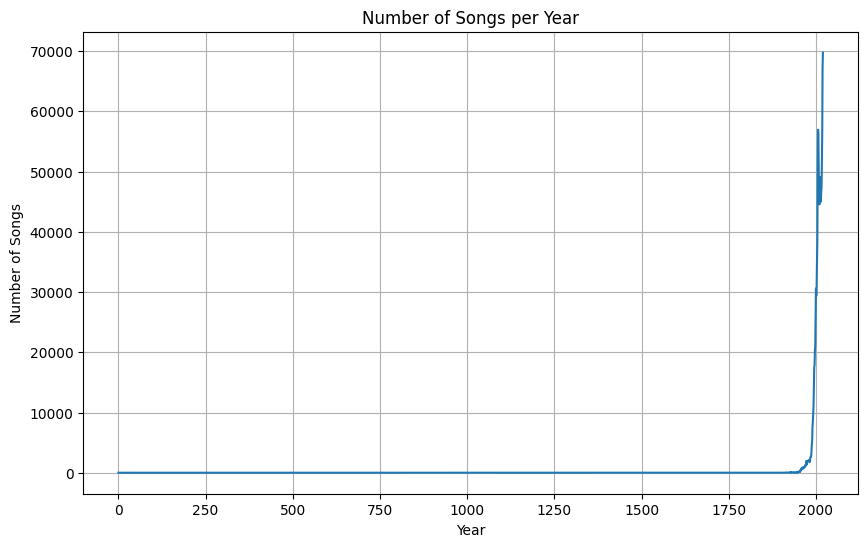

In [ ]:
songs_per_year = tracks_raw_df['year'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
songs_per_year.plot(kind='line')
plt.title('Number of Songs per Year')
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.grid(True)
plt.show()

Inferences:
- The dataset contains a limited number of songs from the pre-1990s era.
- There are outliers present where the year is recorded as '0', which is likely an error.
- Data cleaning will be necessary to address and remove these outliers.

## 3.6: Assessing Distribution and Identifying Outliers in Song Attributes

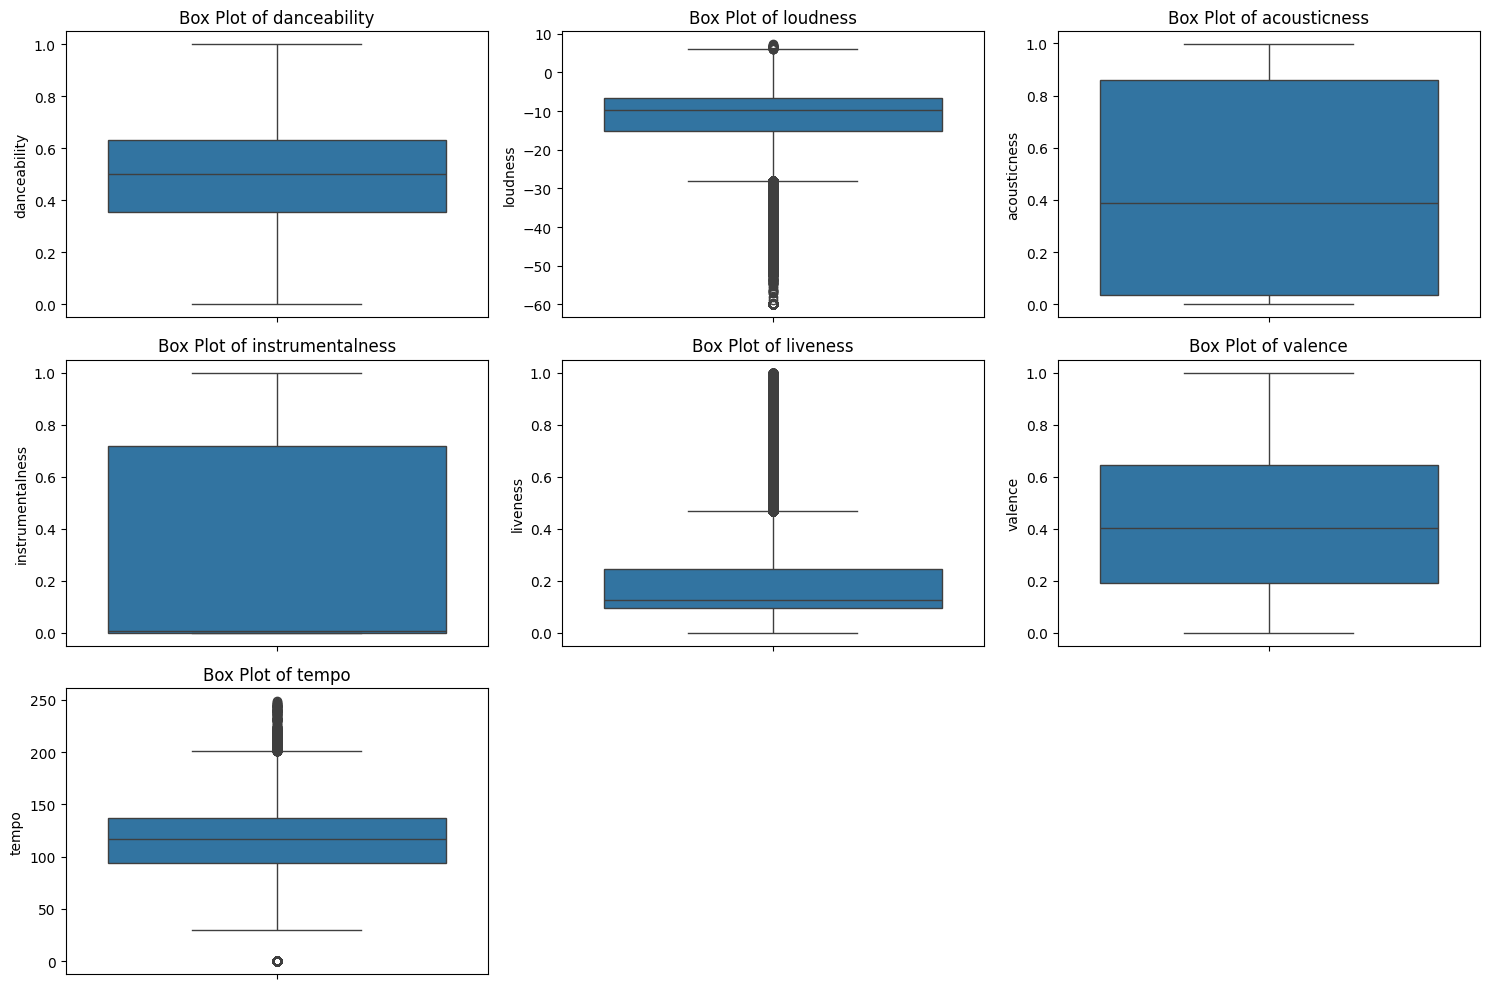

In [ ]:
plt.figure(figsize=(15, 10))

for i, variable in enumerate(variables):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=tracks_raw_df[variable])
    plt.title(f'Box Plot of {variable}')

plt.tight_layout()
plt.show()

**Inferences:**

- **Danceability**: The majority of songs have moderate to high danceability, with a relatively compact interquartile range, indicating less variability and a tendency towards more danceable tracks.
  
- **Loudness**: There's a wide range of loudness levels, with some outliers on the quieter end. The bulk of the data is skewed towards higher loudness levels.
  
- **Acousticness**: Songs show varied degrees of acousticness, with many tracks displaying moderate to high acoustic features.
  
- **Instrumentalness**: The box plot is compact, suggesting that a large number of songs have a lower presence of instrumental elements, but there are also tracks that are highly instrumental.
  
- **Liveness**: Most songs have low liveness, implying studio recordings are more common than live tracks in this dataset. The long whisker and outliers suggest some tracks have much higher liveness.
  
- **Valence**: Songs display a wide spectrum of valence, with a fairly even distribution across the dataset, indicating a variety of moods from sad to happy in the songs.
  
- **Tempo**: There's a broad distribution of tempo with several outliers, indicating that while there's a concentration of songs within a certain tempo range, there are exceptional tracks with very high or low tempos.

# Part 4 : Data Cleaning and Pre-processing

### Feature Extraction

The Charts dataset has a URL column, and each URL has the track ID in it. Since we need to join on the ID with the tracks list, we need to extract the track ID from the URL. We will create a new column called 'track_id' in the Charts dataset by extracting the track ID from the URL.

In [ ]:
%%spark
from pyspark.sql.functions import split, col
charts_raw_sdf = charts_raw_sdf.withColumn('track_id', split(charts_raw_sdf['url'], '/').getItem(4))
# charts_raw_sdf.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Another data cleaning step we decided to perform is compacting the charts dataset to one row per song.

The raw dataset is a timeseries data that lists the songs in the chart and their relative position since the previous week, along with rank in current week. Since we're working with a binary classifier that aims to predict whether a song will go viral based on its features, we decided to keep only the highest rank for each song in the dataset.

This way, we can have a single row per song, with the highest rank it achieved in the chart.

In [ ]:
%%spark
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, min, col


window_spec = Window.partitionBy('title').orderBy('rank')
charts_raw_sdf = charts_raw_sdf.withColumn('row_number', row_number().over(window_spec))
charts_raw_sdf = charts_raw_sdf.filter(col('row_number') == 1).drop('row_number')
charts_raw_sdf = charts_raw_sdf.orderBy('rank', 'date')
charts_raw_sdf = charts_raw_sdf.select("*").withColumn("index", row_number().over(Window.orderBy("rank"))).drop("index")
# charts_raw_sdf.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In the raw dataset, the artists column is a string that looks like an array with the [] and each artist in it separated by a comma. We're stripping the the brackets and quotes and splitting the string by comma to get a list of artists for each song.

We're then creating a new column called 'artists' in the Charts dataset with the list of artists for each song.

In [ ]:
%%spark

from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

def clean_artists(column):
    return [artist.strip("['']") for artist in column.split(", ")]

clean_artists_udf = udf(clean_artists, ArrayType(StringType()))

tracks_cleaned_df = tracks_raw_sdf.withColumn("artists", clean_artists_udf("artists"))
tracks_cleaned_df = tracks_cleaned_df.withColumn("artist_ids", clean_artists_udf("artist_ids"))
# tracks_cleaned_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark

tracks_cleaned_df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1204025

In [ ]:
%%spark
from pyspark.sql.functions import col, size, explode

tracks_cleaned_df = tracks_cleaned_df.filter(size(col("artists")) == size(col("artist_ids")))

# tracks_cleaned_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Once we have a list of artists in the format that Spark can work with, we're going to explode on it to get a unique row for every song for every artist. However, we noticed errors in the dataset where some lists of artists did not have an equivalent sized list of artist_ids and vice versa. We decided to drop these rows from the dataset by only filtering out rows where the length of the artist array is equal to the length of the artist_id array.

From that, we've created a column that zips every artist with their ID, and then exploded each row per item, so that we have a matching artist ID for each artist in the list.

In [ ]:
%%spark
from pyspark.sql import functions as F

tracks_cleaned_df = tracks_cleaned_df.withColumn("artists_and_ids",F.arrays_zip("artists", "artist_ids"))
tracks_cleaned_df = tracks_cleaned_df.withColumn("artists_and_ids",F.explode("artists_and_ids"))
tracks_cleaned_df = tracks_cleaned_df.select(
    F.col("id"),
    F.col("name"),
    F.col("album"),
    F.col("album_id"),
    F.col("track_number"),
    F.col("disc_number"),
    F.col("explicit"),
    F.col("danceability"),
    F.col("energy"),
    F.col("key"),
    F.col("loudness"),
    F.col("mode"),
    F.col("speechiness"),
    F.col("acousticness"),
    F.col("instrumentalness"),
    F.col("liveness"),
    F.col("valence"),
    F.col("tempo"),
    F.col("duration_ms"),
    F.col("time_signature"),
    F.col("year"),
    F.col("release_date"),
    F.col("artists_and_ids.artists").alias("artists"),
    F.col("artists_and_ids.artist_ids").alias("artist_ids")
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Finally, we're only keeping the songs where the year of release is greater than 1990. This is because we noticed in the EDA that majority of the songs are beyond 1990, and any trend in the attributes of a song were only noticable after 1990. Thus we treat the rest as outliers and focus on the crux of the dataset. Moreover, it also helps in removing rows with the issue where year was 0 in the dataset.

Finally, we drop any null values across the dataset.

In [ ]:
%%spark

tracks_cleaned_df = tracks_cleaned_df.filter(tracks_cleaned_df['year'] > 1990)
# tracks_cleaned_df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark

tracks_cleaned_df = tracks_cleaned_df.dropna()
# tracks_cleaned_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Merged Dataset

Finally, we merge the two datasets. This was one of the areas where Spark really helped us, as with a large dataset and millions of rows, we would face RAM spikes and runtime issues if we tried to merge on colab with pandas.
We're merging the dataset on the track_id field in the Charts dataset and the id field in the Tracks dataset. We're performing an inner join to keep only the songs that are present in both datasets.

In [ ]:
%%spark

merged_sdf = charts_raw_sdf.join(tracks_cleaned_df, charts_raw_sdf['track_id'] == tracks_cleaned_df['id'], 'inner')
# merged_sdf.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark

merged_sdf.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

9828

### Plot of danceability and energy of artists in the top charts.

In [ ]:
%%spark
from pyspark.sql.functions import avg, regexp_replace

grouped = merged_sdf.groupby('artists').agg(avg('energy').alias('energy'), avg('danceability').alias('danceability'))
grouped = grouped.withColumn('artists', regexp_replace('artists', '[^\w\s]', ''))

grouped_pandas = grouped.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

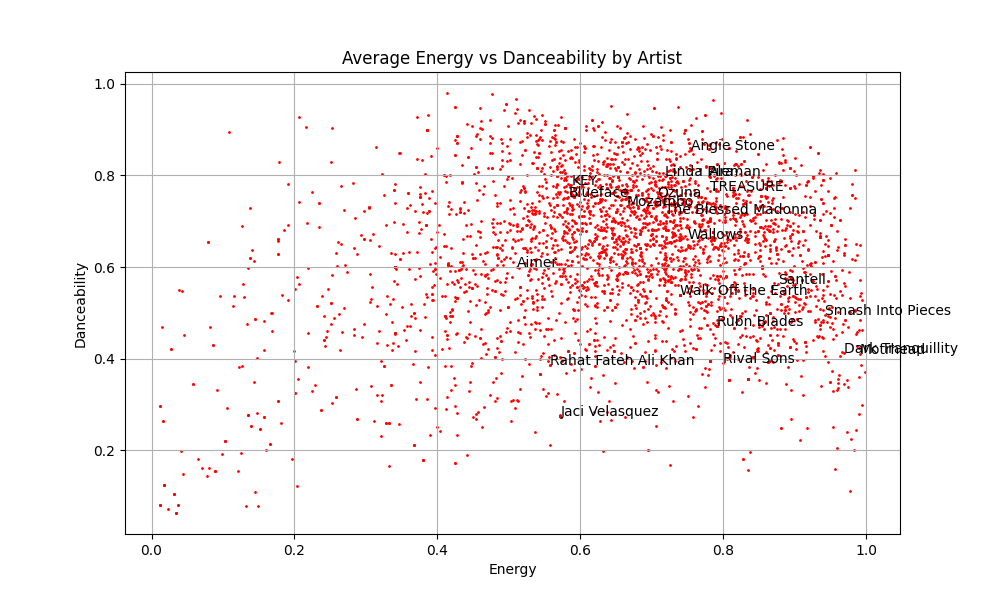

In [ ]:
%%spark

import matplotlib.pyplot as plt
import random

plt.figure(figsize=(10, 6))
plt.scatter(grouped_pandas['energy'], grouped_pandas['danceability'], color='red', s=1)

artists_to_label = random.sample(grouped_pandas['artists'].tolist(), 20)

# Add text for the selected artists
for index, row in grouped_pandas.iterrows():
    if row['artists'] in artists_to_label:
        plt.text(row['energy'], row['danceability'], row['artists'])

# Add labels and title
plt.xlabel('Energy')
plt.ylabel('Danceability')
plt.title('Average Energy vs Danceability by Artist')

# Show plot
plt.grid(True)
plt.show()
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

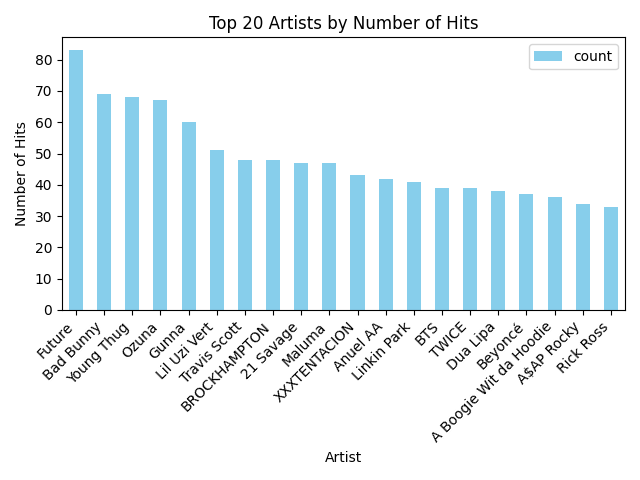

In [ ]:
%%spark
from pyspark.sql import functions

artist_counts = merged_sdf.groupBy('artists').count()
artist_counts = artist_counts.orderBy(functions.desc('count'))
artist_counts = artist_counts.limit(20)
artist_counts = artist_counts.toPandas()
artist_counts = artist_counts[['artists', 'count']]
artist_counts.set_index('artists', inplace=True)

artist_counts
plt.figure(figsize=(12, 6))
artist_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Artist')
plt.ylabel('Number of Hits')
plt.title('Top 20 Artists by Number of Hits')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

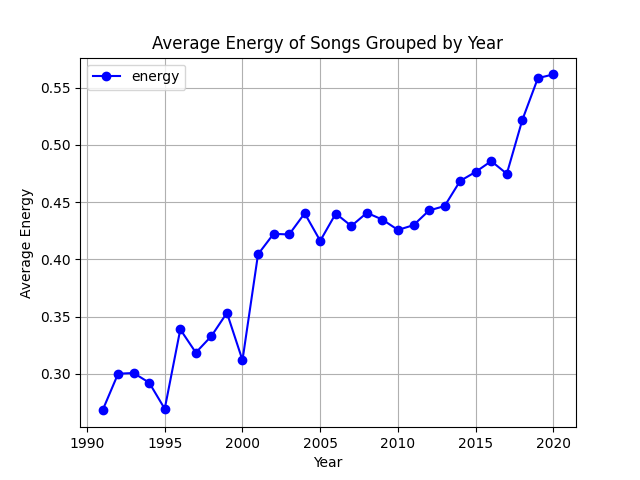

In [ ]:
%%spark
from pyspark.sql import functions

tracks_cleaned_sdf_filtered = tracks_cleaned_df.filter(tracks_cleaned_df['year'] >= 1990)
avg_energy_by_year = tracks_cleaned_sdf_filtered.groupBy('year').agg(functions.mean('energy').alias('energy'))
avg_energy_by_year = avg_energy_by_year.toPandas()

avg_energy_by_year.set_index('year', inplace=True)
avg_energy_by_year = avg_energy_by_year.sort_values(by='year')
avg_energy_by_year
plt.figure(figsize=(10, 6))
avg_energy_by_year.plot(color='blue', marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Average Energy')
plt.title('Average Energy of Songs Grouped by Year')
plt.grid(True)
plt.show()
%matplot plt

# Part 5: Classification Models


## Part 5.0: Cleaning

### Creating required columns

Before we start with the classification models, we need to create a column that will be used as features in the models. We create a *is_viral* column that will be our target variable. We set this column to 1 if the song has ever been in the top top charts, or 0 otherwise.

This is similar to performing a left join on the tracks dataset with the charts dataset, and setting the is_viral column to 1 if the song is present in the charts dataset, and 0 otherwise.

In [ ]:
%%spark

# tracks_cleaned_df['is_viral'] = tracks_cleaned_df['id'].isin(merged_sdf['id']).astype(int)

from pyspark.sql import functions

ids_list = [row['id'] for row in merged_sdf.select('id').distinct().collect()]
tracks_cleaned_df = tracks_cleaned_df.withColumn(
    'is_viral',
    functions.when(functions.col('id').isin(ids_list), 1).otherwise(0)
)

tracks_cleaned_df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1669353

In [ ]:
%%spark

tracks_cleaned_df_pd = tracks_cleaned_df.toPandas()

In [ ]:
%%spark

classification_df = tracks_cleaned_df_pd.copy()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark
classification_df.drop(columns=['id', 'name', 'album', 'album_id','artists', 'artist_ids',
       'track_number', 'disc_number', 'release_date'], inplace=True)
classification_df.reset_index(inplace=True, drop=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Part 5.1: Logistic Regression Model

We commence our classification task of determining whether a song is "viral" or not by employing a simple logistic regression model for binary classification. We opt for Logistic Regression due to its array of advantageous features:

1. **Efficiency**: Logistic Regression stands out for its computational efficiency, rendering it well-suited for handling large datasets. Its ability to converge quickly makes it particularly advantageous when computational resources are limited or when dealing with extensive data volumes

2. **Scalability**: Logistic Regression exhibits scalability, enabling effective modeling of high-dimensional data comprising numerous features. It adeptly manages datasets with a large number of predictors without necessitating significant computational overhead, thereby mitigating issues related to the curse of dimensionality

3. **Probabilistic Outputs**: A key strength of Logistic Regression lies in its provision of probabilistic outputs. These probabilities serve as confidence levels, enabling straightforward interpretation and allowing for flexible threshold adjustments to suit the requirements of diverse applications

4. **Robustness to Irrelevant Features**: Logistic Regression demonstrates robustness in handling irrelevant features gracefully. By assigning low weights or zero coefficients to irrelevant predictors, it effectively filters out noise from the dataset


In [ ]:
%%spark

X = classification_df.copy()
X = X.drop('is_viral', axis=1)
X.fillna(X.mean(), inplace=True)
y = classification_df['is_viral']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y)
X_train = pd.DataFrame(X_train, columns=list(classification_df.columns[:-1]))
y_train = pd.Series(y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

log_reg = LogisticRegression(random_state=96)
log_reg.fit(X_train, y_train)
log_reg_predictions = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_reg_predictions))
print("Logistic Regression Report:\n", classification_report(y_test, log_reg_predictions))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression Accuracy: 0.994117488491064
Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    331907
           1       0.00      0.00      0.00      1964

    accuracy                           0.99    333871
   macro avg       0.50      0.50      0.50    333871
weighted avg       0.99      0.99      0.99    333871

/usr/local/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Here are some inferences that can be drawn from the report and confusion matrix:

1. **High Overall Accuracy but Potentially Misleading**: The model has a very high accuracy of approximately 99.41%. However, accuracy is not always the best metric to rely on.

2. **Poor Performance on Minority Class (Class '1')**: The precision, recall, and f1-score for class '1' are all 0. This means the model failed to correctly identify any true positives for the minority class. In practical terms, while the model is very good at predicting the majority class (class '0'), it fails entirely at predicting the minority class (class '1').

3. **Excellent Performance on Majority Class (Class '0')**: The precision, recall, and f1-score for class '0' are all 0.99 or 1, which indicates that the model performs very well on the majority class.

4. **F1-Score**: The f1-score combines precision and recall into a single metric. A score of 1 for class '0' is excellent, but a score of 0 for class '1' is problematic.

5. **Need for Model Improvement**: The model needs to be improved to handle class '1' better. Techniques such as resampling the data, trying different algorithms, or using class weights to adjust the imbalance might be necessary.

From this report, while the high accuracy might initially seem impressive, the reality is that the model is not performing well in a critical area: correctly classifying instances of the minority class.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

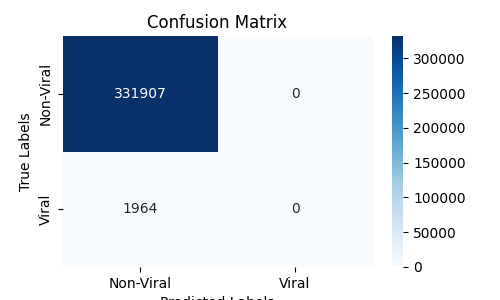

In [ ]:
%%spark

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, log_reg_predictions)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Viral', 'Viral'], yticklabels=['Non-Viral', 'Viral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

%matplot plt

1. We see that the above model always predicts every song to not go viral. This is because there is a class imbalance in the above dataset.

2. Upsampling is employed to address class imbalance, a common issue in classification tasks where one class significantly outnumbers the other. In this scenario, the minority class (viral songs) are underrepresented in the training data, leading to biased model predictions.
3. By upsampling the minority class to match the number of samples in the majority class (non-viral songs), we create a balanced training dataset.
4. This ensures that the model is exposed to an equal representation of both classes during training, allowing it to learn robust decision boundaries and make more accurate predictions for both classes.

In [ ]:
%%spark

X = classification_df.copy()
X = X.drop('is_viral', axis=1)
X.fillna(X.mean(), inplace=True)
y = classification_df['is_viral']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y)
X_train = pd.DataFrame(X_train, columns=list(classification_df.columns[:-1]))
y_train = pd.Series(y_train)

X = pd.concat([X_train, y_train], axis=1)

minority = X[X['is_viral'] == 1]
majority = X[X['is_viral'] == 0]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark

counts = X['is_viral'].value_counts()

# Display the counts
print("Number of rows with is_viral = 0:", counts[0])
print("Number of rows with is_viral = 1:", counts[1])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows with is_viral = 0: 1327627
Number of rows with is_viral = 1: 7855

In [ ]:
%%spark

minority_upsampled = resample(minority,
                              replace=True,
                              n_samples=len(majority),
                              random_state=42)

upsampled = pd.concat([majority, minority_upsampled])
X_train = upsampled.drop('is_viral', axis=1)
y_train = upsampled['is_viral']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark

log_reg = LogisticRegression(random_state=96)
log_reg.fit(X_train, y_train)

log_reg_predictions = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_reg_predictions))
print("Logistic Regression Report:\n", classification_report(y_test, log_reg_predictions))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression Accuracy: 0.7921083292648957
Logistic Regression Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88    331907
           1       0.02      0.87      0.05      1964

    accuracy                           0.79    333871
   macro avg       0.51      0.83      0.47    333871
weighted avg       0.99      0.79      0.88    333871

We retrain a Logistic Regression model after upsampling the training data, specifically focusing on the minority class represented by viral songs. By addressing class imbalance through upsampling, we aim to observe potential changes in model performance metrics

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

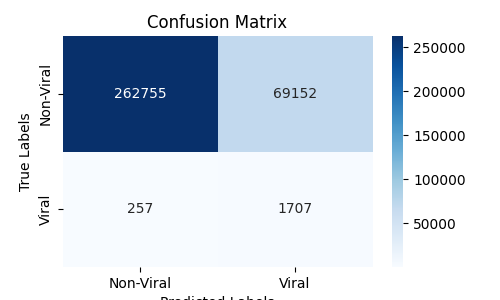

In [ ]:
%%spark
# Calculate confusion matrix
cm = confusion_matrix(y_test, log_reg_predictions)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Viral', 'Viral'], yticklabels=['Non-Viral', 'Viral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

%matplot plt

1. **Reduction in False Negatives**: Compared to the earlier classification report where the model failed to identify any positives for the minority class, this model now identifies 1,707 true positives. This suggests that upscaling has had a positive effect on the model's ability to detect the minority class.

2. **Increase in False Positives**: Upscaling seems to have increased the number of false positives substantially. While the model is now catching more of the minority class, it is also misclassifying a significant number of majority class instances.

In conclusion, upscaling has allowed the model to identify instances of the minority class it previously missed but at the cost of a higher false positive rate for the majority class. It indicates progress in the right direction, but further tuning is necessary to optimize the model's performance.

## Part 5.2: Neural Network based models

We demonstrate the utilization of a Neural Network-based model for our binary classification task targeting the variable "is_viral." This decision is driven by several advantages over a logistic regression model:

1. **Non-linearity Handling**: Neural networks excel in capturing complex non-linear relationships between features and the target variable. In datasets with class imbalance, intricate patterns may exist that logistic regression, being a linear model, might struggle to capture effectively.

2. **Feature Representation Learning**: Neural networks possess the capability to automatically learn meaningful feature representations from raw data. In datasets with class imbalance, subtle features that strongly indicate one class over the other can be learned by neural networks, potentially leading to improved classification performance.

3. **Ability to Handle Imbalanced Datasets**: Unlike logistic regression, which can be sensitive to class imbalance, neural networks offer greater flexibility in handling such datasets. They can employ various techniques such as class weighting, oversampling, or specialized loss functions to effectively address class imbalance issues and improve model performance.

By leveraging the strengths of neural networks, we aim to build a robust binary classification model that can effectively handle non-linear relationships, learn informative feature representations, and adapt to imbalanced datasets, ultimately leading to enhanced predictive accuracy and performance.

In [ ]:
%%spark
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Part 5.2.1: Simple Neural Network

The model architecture comprises two fully connected (dense) layers, denoted as `fc1` and `fc2`, with non-linear activation functions applied between them. Specifically, Rectified Linear Unit (ReLU) activation is applied after the first layer (`fc1`) to introduce non-linearity and learn abstract representations of the input features. Subsequently, the output from `fc1` is passed through a Sigmoid activation function before reaching the final output neuron in the second layer (`fc2`).

In this architecture:
- `fc1` learns abstract representations of the input features, capturing complex patterns and relationships within the data.
- `fc2` maps these learned representations to a single output neuron, which produces the final prediction for the binary classification task.

The Sigmoid activation function applied to the output neuron ensures that the model's predictions are constrained within the range [0, 1]. This property is particularly advantageous for binary classification tasks, where the output represents the probability of belonging to the positive class. By producing probability estimates, the model's output can be interpreted directly as confidence scores for each class, facilitating decision-making and uncertainty estimation.

Overall, the combination of dense layers with non-linear activations, culminating in a Sigmoid output layer, equips the model to effectively capture complex relationships in the data and generate meaningful predictions for binary classification problems.


In [ ]:
%%spark

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # unsqueeze to make it a column vector

# Create a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 4
model = SimpleNN(input_size, hidden_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

`nn.BCELoss` initializes the binary cross-entropy loss function. This loss function is commonly used for binary classification tasks to measure the difference between predicted probabilities and actual class labels.

`optim.Adam` selects the Adam optimizer. The optimizer is responsible for updating the model's parameters during training to minimize the loss.

In [ ]:
%%spark

# Training loop
simple_nn_loss_list = []
simple_nn_accuracy_list = []
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        correct += (predicted == labels).sum()
        total += labels.size(0)
    epoch_accuracy = correct / total * 100
    simple_nn_loss_list.append(running_loss)
    simple_nn_accuracy_list.append(epoch_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {epoch_accuracy:.4f}%")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Epoch [1/10], Loss: 1911.5692, Accuracy: 84.7320%
Epoch [2/10], Loss: 1889.2080, Accuracy: 84.9443%
Epoch [3/10], Loss: 1888.3632, Accuracy: 84.9463%
Epoch [4/10], Loss: 1888.0388, Accuracy: 84.9423%
Epoch [5/10], Loss: 1887.5614, Accuracy: 84.9466%
Epoch [6/10], Loss: 1887.4795, Accuracy: 84.9306%
Epoch [7/10], Loss: 1887.6976, Accuracy: 84.9208%
Epoch [8/10], Loss: 1887.2093, Accuracy: 84.9365%
Epoch [9/10], Loss: 1887.6711, Accuracy: 84.9325%
Epoch [10/10], Loss: 1886.5944, Accuracy: 84.9305%

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

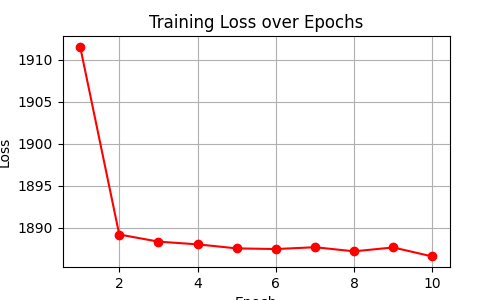

In [ ]:
%%spark

# Plot loss
plt.figure(figsize=(5, 3))
plt.plot(range(1, num_epochs+1), simple_nn_loss_list, marker='o', color='red')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

%matplot plt

Inferences:
- The training loss starts very high but drops sharply after the first epoch, indicating rapid learning initially.
- After this drop, the loss decreases slowly and steadies out, showing the model is stabilizing and making smaller updates to the weights.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

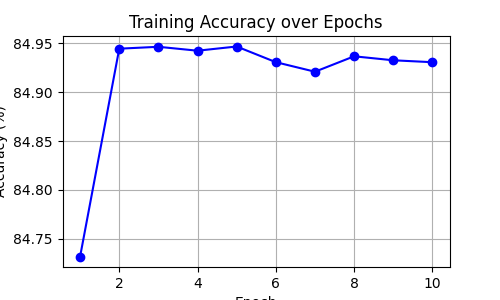

In [ ]:
%%spark
# Plot accuracy
plt.figure(figsize=(5, 3))
plt.plot(range(1, num_epochs+1), simple_nn_accuracy_list, marker='o', color='blue')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

%matplot plt

Inferences:
- The training accuracy increases significantly after the first epoch, which aligns with the large decrease in loss.
- The accuracy then plateaus, with minor fluctuations, suggesting the model has reached its performance capacity with the given architecture and data.

In [ ]:
%%spark

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

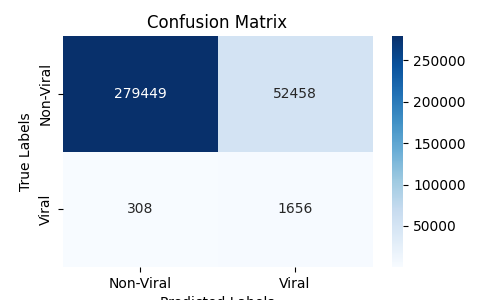

In [ ]:
%%spark

with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    predictions = (outputs >= 0.5).float()  # Convert probabilities to binary predictions
    accuracy = (predictions == y_test_tensor).float().mean().item() * 100
    print(f"Test Accuracy: {accuracy:.4f}%\n")

    # Confusion Matrix
    cm = confusion_matrix(y_test_tensor, predictions)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Viral', 'Viral'], yticklabels=['Non-Viral', 'Viral'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("\nSimple Neural Network Classification Report:\n")
    report = classification_report(y_test_tensor, predictions, target_names=['Non-Viral', 'Viral'])
    print(report)

%matplot plt

Inferences:
- The true negatives (Non-Viral correctly identified as Non-Viral) are high at 279,449, which is good for the Non-Viral class prediction.
- The false positives (Non-Viral incorrectly identified as Viral) are significantly fewer at 52,458 compared to the previous upscaling model.
- There is a slight decrease in false negatives (Viral incorrectly identified as Non-Viral) to 308 from the previous 257, indicating a very marginal decline in performance for detecting the Viral class.
- The true positives (Viral correctly identified as Viral) have slightly decreased to 1,656 from the previous 1,707, indicating a slight drop in correctly identifying the Viral cases after applying the neural network approach.
- This neural network model seems to be more balanced between both classes than the previous models, with fewer false positives and a small change in true positives and false negatives.

### Part 5.2.2: Neural Network with Decaying Loss function

Below defines a similar Neural Network class as defined in Part 5.2.1

In [ ]:
%%spark

class WeightedSimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(WeightedSimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark

from torch.optim.lr_scheduler import StepLR

input_size = X_train.shape[1]
hidden_size = 7
model = WeightedSimpleNN(input_size, hidden_size)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define learning rate scheduler with step decay
scheduler = StepLR(optimizer, step_size=1, gamma=0.05)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An improvement on the neural network defined in part 5.2.1 is described below

`StepLR` defines a learning rate scheduler with step decay. This scheduler adjusts the learning rate of the optimizer at specified intervals (`step_size`) by a multiplicative factor (`gamma`). In this case, the learning rate will decrease by a factor of 0.05 after every epoch.

In [ ]:
%%spark

num_epochs = 10
weighted_nn_loss_list = []
weighted_nn_accuracy_list = []
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    epoch_accuracy = correct / total * 100
    weighted_nn_loss_list.append(running_loss)
    weighted_nn_accuracy_list.append(epoch_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {epoch_accuracy:.4f}%")
    # Update the learning rate
    scheduler.step()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Epoch [1/10], Loss: 1881.3773, Accuracy: 84.9035%
Epoch [2/10], Loss: 1852.7278, Accuracy: 85.1417%
Epoch [3/10], Loss: 1851.5888, Accuracy: 85.1332%
Epoch [4/10], Loss: 1851.4568, Accuracy: 85.1342%
Epoch [5/10], Loss: 1851.5712, Accuracy: 85.1352%
Epoch [6/10], Loss: 1851.7454, Accuracy: 85.1352%
Epoch [7/10], Loss: 1851.4983, Accuracy: 85.1352%
Epoch [8/10], Loss: 1851.5475, Accuracy: 85.1352%
Epoch [9/10], Loss: 1851.7003, Accuracy: 85.1352%
Epoch [10/10], Loss: 1851.3894, Accuracy: 85.1352%

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

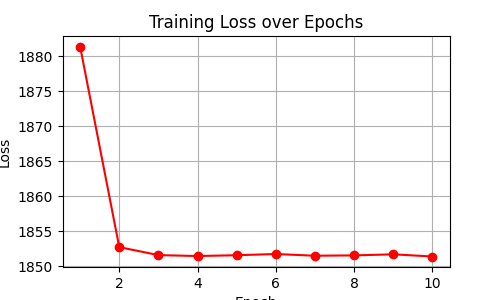

In [ ]:
%%spark

# Plot loss
plt.figure(figsize=(5, 3))
plt.plot(range(1, num_epochs+1), weighted_nn_loss_list, marker='o', color='red')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

%matplot plt

Inferences:
- There's a rapid decline in training loss between the first two epochs similar to the previous run without learning rate decay, but the overall loss values are slightly lower, indicating a more optimized learning process.
- The loss appears more stable across epochs compared to the previous training without learning rate decay, possibly due to the finer adjustments in learning rate.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

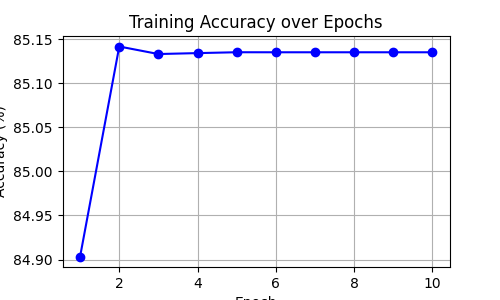

In [ ]:
%%spark

# Plot accuracy
plt.figure(figsize=(5, 3))
plt.plot(range(1, num_epochs+1), weighted_nn_accuracy_list, marker='o', color='blue')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

%matplot plt

Inferences:
- The accuracy improves swiftly as before and then plateaus, but this time the plateau is at a marginally higher accuracy level than without learning rate decay.
- The training accuracy remains very consistent from epochs 3 to 10, with less fluctuation, which could suggest that learning rate decay is helping to maintain a stable improvement in accuracy.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

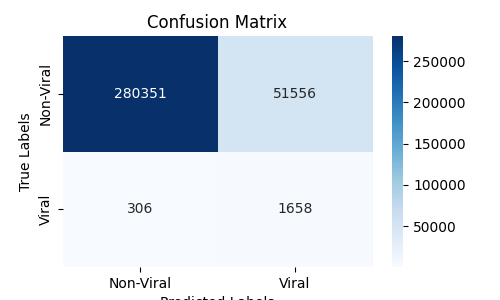

In [ ]:
%%spark

threshold = 0.5
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    predictions = (outputs >= threshold).float()  # Adjusted threshold for binary predictions
    accuracy = 100 * (predictions == y_test_tensor).float().mean()
    print(f"Test Accuracy: {accuracy:.4f}%\n")

    # Confusion Matrix
    cm = confusion_matrix(y_test_tensor, predictions)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Viral', 'Viral'], yticklabels=['Non-Viral', 'Viral'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision, Recall, F1 Score
    precision = precision_score(y_test_tensor, predictions)
    recall = recall_score(y_test_tensor, predictions)
    f1 = f1_score(y_test_tensor, predictions)
    print(f"\nPrecision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    print("\nSimple Neural Network Report with Decaying Loss Classification Report:\n")
    report = classification_report(y_test_tensor, predictions, target_names=['Non-Viral', 'Viral'])
    print(report)

%matplot plt

Inferences:
- True negatives have slightly increased to 280,351 from 279,449, showing a minor improvement in the model's ability to correctly identify Non-Viral classes.
- False positives have decreased to 51,556 from 52,458, indicating a better distinction between classes after applying learning rate decay.
- False negatives have marginally decreased from 308 to 306, a slight improvement in correctly identifying Viral cases.
- True positives for the Viral class are essentially the same, at 1,658 compared to 1,656 previously, indicating stability in identifying the minority class with the learning rate decay.
- These changes suggest that learning rate decay has provided a subtle but positive impact on the model's ability to classify both classes, especially in reducing false positives.

### Part 5.2.2: Complex  Network with Decaying Loss function

The model architecture comprises an input layer, an output layer and multiple fully connected (dense) hindden layers with non-linear activation functions applied between them. Specifically, Rectified Linear Unit (ReLU) activation is applied after the first layer and to all hidden layers to introduce non-linearity and learn abstract representations of the input features. Subsequently, the output from the last hidden layer is passed through a Sigmoid activation function before reaching the final output neuron in the second layer.

In this architecture:
- `input_layer` learns abstract representations of the input features, capturing complex patterns and relationships within the data.
- `output_layer` maps these learned representations to a single output neuron, which produces the final prediction for the binary classification task.
- `hidden_layers` increase the complexity of the model to achieve better generalisation, represent the feature space in a complex data structure to learn the intricate relationships between subsets of features and better capture atterns and relationships that may exist in the data

In [ ]:
%%spark

import torch.nn.functional as F

# Define a deeper neural network architecture
class ComplexNN(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(ComplexNN, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes

        # Define input layer
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])

        # Define hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        # Define output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], 1)

    def forward(self, x):
        x = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = torch.sigmoid(self.output_layer(x))
        return x

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark

# Initialize the model
input_size = X_train.shape[1]
hidden_sizes = [15, 10, 7, 4]  # Example: Four hidden layers
model = ComplexNN(input_size, hidden_sizes)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Define learning rate scheduler with step decay
scheduler = StepLR(optimizer, step_size=2, gamma=0.05)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

This scheduler `StepLR` adjusts the learning rate of the optimizer at specified intervals (`step_size`) by a multiplicative factor (`gamma`). In this case, the learning rate will decrease by a factor of 0.05 after every 2 epochs

In [ ]:
%%spark

complex_nn_loss_list = []
complex_nn_accuracy_list = []
num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    scheduler.step()
    epoch_accuracy = 100 * correct / total
    complex_nn_loss_list.append(running_loss)
    complex_nn_accuracy_list.append(epoch_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {epoch_accuracy:.4f}%")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Epoch [1/20], Loss: 1760.5327, Accuracy: 86.1045%
Epoch [2/20], Loss: 1662.1949, Accuracy: 86.9173%
Epoch [3/20], Loss: 1610.9927, Accuracy: 87.2889%
Epoch [4/20], Loss: 1605.8736, Accuracy: 87.3361%
Epoch [5/20], Loss: 1603.1928, Accuracy: 87.3743%
Epoch [6/20], Loss: 1602.8400, Accuracy: 87.3836%
Epoch [7/20], Loss: 1602.6001, Accuracy: 87.3948%
Epoch [8/20], Loss: 1602.4816, Accuracy: 87.4028%
Epoch [9/20], Loss: 1602.5540, Accuracy: 87.4033%
Epoch [10/20], Loss: 1602.5671, Accuracy: 87.4035%
Epoch [11/20], Loss: 1602.4013, Accuracy: 87.4036%
Epoch [12/20], Loss: 1602.6545, Accuracy: 87.4036%
Epoch [13/20], Loss: 1602.4281, Accuracy: 87.4036%
Epoch [14/20], Loss: 1602.6575, Accuracy: 87.4036%
Epoch [15/20], Loss: 1602.5357, Accuracy: 87.4036%
Epoch [16/20], Loss: 1602.4189, Accuracy: 87.4036%
Epoch [17/20], Loss: 1602.3643, Accuracy: 87.4036%
Epoch [18/20], Loss: 1602.5007, Accuracy: 87.4036%
Epoch [19/20], Loss: 1602.4984, Accuracy: 87.4036%
Epoch [20/20], Loss: 1602.6850, Accuracy

// Write observations

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

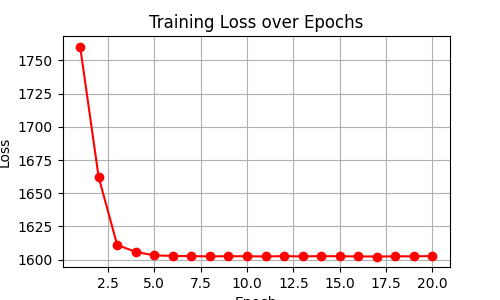

In [ ]:
%%spark

# Plot loss
plt.figure(figsize=(5, 3))
plt.plot(range(1, num_epochs+1), complex_nn_loss_list, marker='o', color='red')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

%matplot plt

Inferences:
- The loss drops even more substantially from the first to the second epoch, indicating a stronger initial learning effect. After this, it shows a steady and more gradual decline, which suggests that the added complexity of the neural network allows for finer feature extraction and learning over a longer period.
- The final loss levels out at a lower value than the simpler model, which could mean that the complex model is capturing the nuances of the data better.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

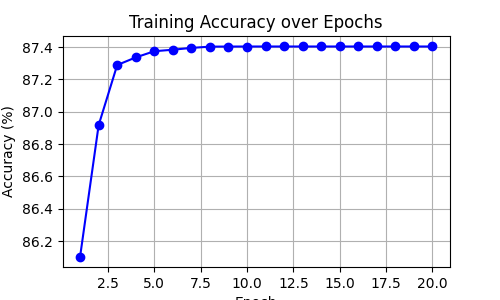

In [ ]:
%%spark

# Plot accuracy
plt.figure(figsize=(5, 3))
plt.plot(range(1, num_epochs+1), complex_nn_accuracy_list, marker='o', color='blue')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

%matplot plt

Inferences:
- The training accuracy increases more rapidly and reaches a higher peak early on, which may reflect the model's improved capacity for learning from the data due to its complexity.
- There's less fluctuation in the accuracy across epochs compared to the simpler model, possibly indicating that the complex model has a more stable learning trajectory with learning rate decay implemented.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

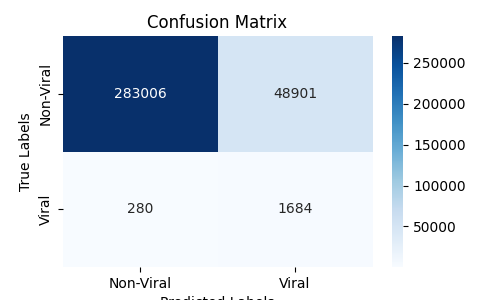

In [ ]:
%%spark
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    predictions = (outputs >= 0.5).float()  # Convert probabilities to binary predictions
    accuracy = (predictions == y_test_tensor).float().mean().item() * 100
    print(f"Test Accuracy: {accuracy:.4f}%\n")

    # Confusion Matrix
    cm = confusion_matrix(y_test_tensor, predictions)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Viral', 'Viral'], yticklabels=['Non-Viral', 'Viral'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision, Recall, F1 Score
    precision = precision_score(y_test_tensor, predictions)
    recall = recall_score(y_test_tensor, predictions)
    f1 = f1_score(y_test_tensor, predictions)
    print(f"\nPrecision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    print("\nComplex Neural Network Report with Decaying Loss Classification Report:\n")
    report = classification_report(y_test_tensor, predictions, target_names=['Non-Viral', 'Viral'])
    print(report)

%matplot plt

Inferences:
- The number of true negatives is slightly higher at 283,006 compared to 280,351, suggesting that the more complex model is slightly better at identifying Non-Viral cases correctly.
- The false positives have reduced to 48,901 from 51,556, showing that the model has become better at reducing misclassification of Non-Viral as Viral.
- The number of false negatives is slightly lower at 280 compared to 306, indicating an incremental improvement in detecting Viral cases.
- True positives for the Viral class have slightly increased to 1,684 from 1,658, showing a minor improvement in the model's ability to correctly classify Viral instances.
- Overall, the increased complexity of the neural network, combined with learning rate decay, seems to have provided marginal improvements across all aspects of the model's predictive capabilities.

## Part 5.3: Decision Tree Based Models

We showcase how we utilize a Decision Tree-based model for our binary classification task targeting the variable "is_viral"

This decision stems from several advantages over neural network-based models:

1. **Robustness to Irrelevant Features**: Decision Tree models exhibit robustness to irrelevant features and excel in handling high-dimensional data without necessitating extensive feature engineering.

2. **Interpretability**: Decision Trees are inherently more interpretable compared to neural networks. Their transparent nature enables better understanding and insight into the decision-making process, facilitating more effective generalization.

3. **Ease of Hyperparameter Tuning**: Decision Tree-based models offer simplified hyperparameter tuning compared to complex neural networks. This ease streamlines the optimization process, leading to more efficient model development.

4. **Ensemble Learning with Random Forests**: Leveraging ensemble learning techniques such as Random Forests enables us to enhance generalization, a crucial aspect, particularly in handling imbalanced datasets like ours.

5. **Class Imbalance Handling**: Random Forest models naturally address class imbalance concerns by adjusting class weights during training. This inherent capability contributes to better model performance, especially in scenarios with uneven class distributions.


### Part 5.3.1: Decision Tree

As a preliminary model, we train a DecisionTreeClassifier in the above cell on our training data and predict the output on our test data

In [ ]:
%%spark

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

decision_tree = DecisionTreeClassifier(random_state=96)

# Train the decision tree model
decision_tree.fit(X_train, y_train)

# Make predictions on the test set
y_pred = decision_tree.predict(X_test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

depth = decision_tree.tree_.max_depth
print("Maximum depth of the decision tree:", depth)
print("\nAccuracy:", accuracy, "%")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nConfusion Matrix:\n")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Maximum depth of the decision tree: 103

Accuracy: 99.35633822644076 %
Precision: 0.45901639344262296
Recall: 0.5274949083503055
F1 Score: 0.49087893864013266

Confusion Matrix:

Inferences:
- **High Tree Depth:** The decision tree has a maximum depth of 103, which is quite deep for a decision tree, suggesting that the model is very complex.
- **Accuracy:** The accuracy is extremely high at 99.36%, but as with previous models, accuracy is not always the best indicator of performance, especially in imbalanced datasets.
- **Precision and Recall:** The precision (0.459) and recall (0.527) for the decision tree model are relatively low. However, they are improvements over the previous neural network model where precision and recall for the minority class were much lower, indicating the decision tree model's better performance in classifying the minority class.
- **F1 Score:** The F1 score, which balances precision and recall, is also low at approximately 0.49, but this is again an improvement over the previous neural network model.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

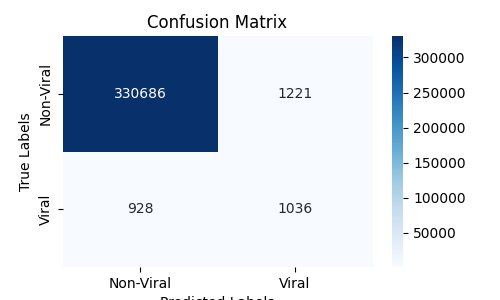

In [ ]:
%%spark

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Viral', 'Viral'], yticklabels=['Non-Viral', 'Viral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

%matplot plt

Inferences:

The improvements in precision, recall, and F1 score from the previous model could be due to several factors:
- Different Model Dynamics: Decision trees make decisions based on rules derived from the data, which might capture certain patterns better than the neural network for this specific dataset.
- Pruning and Depth Control: If the decision tree has been pruned effectively, it can generalize better than a complex neural network which might overfit.
- Feature Splitting: Decision trees handle both numerical and categorical data well and can make use of feature interactions that neural networks might miss without feature engineering.

### Part 5.3.2: Random Forest

We now use a Random Forest Model which is an ensemble learning model used to generalise by taking a majority vote of the output of multiple decision trees which are trained on different bags of subsets of output data

A Random Forest classifier is a natural improvement on a Decision Tree based model. The goal of using this model is to obtain a better Precisiona nd F1-score which would suggest an improvement in dealing with an imbalanced test-set

In [ ]:
%%spark
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=10, random_state=96)

# Train the Random Forest model
random_forest.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = random_forest.predict(X_test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark

min_samples_split = random_forest.min_samples_split
min_samples_leaf = random_forest.min_samples_leaf
depths = [estimator.tree_.max_depth for estimator in random_forest.estimators_]
# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf) * 100
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("Random Forest Model Metrics:\n")
print("Maximum depth of trees:", max(depths))
print("Minimum Sample Split:", min_samples_split)
print("Minimum Sample Leaf:", min_samples_leaf)
print("\nAccuracy:", accuracy_rf , "%")
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)
print("\nConfusion Matrix:\n")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Random Forest Model Metrics:

Maximum depth of trees: 85
Minimum Sample Split: 2
Minimum Sample Leaf: 1

Accuracy: 99.63818360983733 %
Precision: 0.8
Recall: 0.5132382892057027
F1 Score: 0.6253101736972706

Confusion Matrix:

Inferences:

1. **Tree Depth and Minimum Samples**: The model's trees have a maximum depth of 85, with a minimum sample split of 2 and a minimum sample leaf of 1, which are parameters that control the growth of each tree within the forest. These settings indicate that the model is complex and allows trees to grow quite deep, potentially capturing intricate patterns in the data.

2. **Accuracy**: Similar to the decision tree model, this Random Forest model has a high accuracy of approximately 99.64%. This continues to suggest good overall performance but should be interpreted with caution due to the potential imbalance in the dataset.

3. **Precision, Recall, and F1 Score**: The precision has significantly improved to 0.8, indicating a higher proportion of relevant instances among the retrieved instances. The recall is at 0.513, which is slightly lower than the decision tree model but still indicates that over half of the relevant instances are retrieved. The F1 score is 0.625, which is higher than the decision tree's F1 score, showing a better balance between precision and recall.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

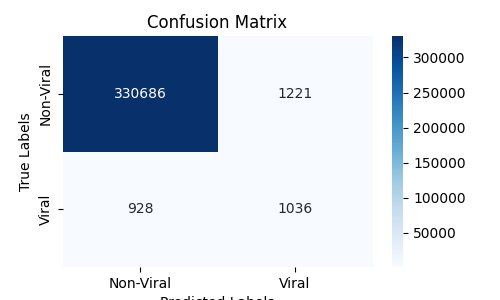

In [ ]:
%%spark

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Viral', 'Viral'], yticklabels=['Non-Viral', 'Viral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

%matplot plt

Inferences:

1. **Ensemble Learning**: Random Forest uses an ensemble of trees which generally improves model performance over a single decision tree by reducing variance (overfitting), even though the trees are allowed to grow large.

2. **Feature Bagging**: Random Forest benefits from feature bagging (random selection of features), which helps in handling the correlation between features by ensuring that trees are decorrelated.

3. **Averaging Predictions**: By averaging predictions from various trees, Random Forest tends to improve the overall prediction and generalizes better than individual trees.

The increase in precision and F1 score indicates that the Random Forest model is more robust, especially for classifying the positive (Viral) class, even though the overall number of correct predictions for this class has not changed. This robustness is likely due to the ensemble effect, which helps to mitigate errors that might occur in individual decision trees.

### Part 5.3.3: Grid Search on Random Forest

To enhance our Random Forest Model, we plan to conduct a grid search for hyperparameter tuning. Specifically, we will explore different values for two key parameters: the number of decision trees in the forest (n_estimators) and the maximum depth allowed for each tree's splits.

The advantages of this approach include:

1. **Comprehensive Parameter Exploration**: By performing a grid search, we systematically investigate a range of parameter values and their combinations. This thorough exploration enables us to identify the most optimal model configuration that maximizes performance metrics.

2. **Mitigation of Overfitting**: Grid search facilitates the identification of hyperparameter values that help reduce overfitting. By fine-tuning parameters such as the number of trees and maximum tree depth, we can build a more robust model that generalizes well to unseen data, thereby enhancing its predictive power.

By leveraging grid search for hyperparameter tuning, we aim to create a Random Forest Model that not only minimizes overfitting but also achieves improved generalization, leading to more accurate and reliable predictions across diverse datasets.


In [ ]:
%%spark

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

param_grid = {
    'n_estimators': [8, 12, 15],
    'max_depth': [80, 100, 150],
}

grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'], refit='f1', verbose=3)

# Perform grid search
grid_search.fit(X_train, y_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_depth=80, n_estimators=8; accuracy: (test=1.000) f1: (test=1.000) precision: (test=0.999) recall: (test=1.000) total time=  45.4s
[CV 2/5] END max_depth=80, n_estimators=8; accuracy: (test=1.000) f1: (test=1.000) precision: (test=0.999) recall: (test=1.000) total time=  46.5s
[CV 3/5] END max_depth=80, n_estimators=8; accuracy: (test=1.000) f1: (test=1.000) precision: (test=0.999) recall: (test=1.000) total time=  45.1s
[CV 4/5] END max_depth=80, n_estimators=8; accuracy: (test=1.000) f1: (test=1.000) precision: (test=0.999) recall: (test=1.000) total time=  44.3s
[CV 5/5] END max_depth=80, n_estimators=8; accuracy: (test=1.000) f1: (test=1.000) precision: (test=0.999) recall: (test=1.000) total time=  45.2s
[CV 1/5] END max_depth=80, n_estimators=12; accuracy: (test=1.000) f1: (test=1.000) precision: (test=0.999) recall: (test=1.000) total time= 1.5min
[CV 2/5] END max_depth=80, n_estimators=12; accuracy: (te

In [ ]:
%%spark

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (Cross-validated F1 Score):", best_score)

# Use the best model for predictions
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate the best model
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf) * 100
precision_best_rf = precision_score(y_test, y_pred_best_rf)
recall_best_rf = recall_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf)
conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)

print("\nBest Random Forest Model Metrics:")
print("Accuracy:", accuracy_best_rf, "%")
print("Precision:", precision_best_rf)
print("Recall:", recall_best_rf)
print("F1 Score:", f1_best_rf)
print("\nConfusion Matrix:\n")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best Parameters: {'max_depth': 80, 'n_estimators': 12}
Best Score (Cross-validated F1 Score): 0.9996329385422975

Best Random Forest Model Metrics:
Accuracy: 99.63908216047516 %
Precision: 0.8014297061159651
Recall: 0.5137474541751528
F1 Score: 0.626124728513807

Confusion Matrix:

Inferences:

1. **Best Parameters and Cross-Validated Score**: The model's best parameters are a maximum depth of 80 and the number of estimators set to 12. The cross-validated F1 score is extremely high (approximately 1.0), which indicates nearly perfect classification on the cross-validation sets. This could suggest overfitting on the validation set or that the cross-validation process might not represent the real-world performance.

2. **Accuracy**: The accuracy remains very high at approximately 99.64%, consistent with the earlier Random Forest model.

3. **Precision, Recall, and F1 Score**: Precision has slightly improved to 0.801 compared to the previous Random Forest model's 0.8. Recall has slightly increased from 0.513 to approximately 0.5137. The F1 score is marginally higher at 0.626 compared to the previous 0.6253, which suggests that the balance between precision and recall has remained almost the same.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

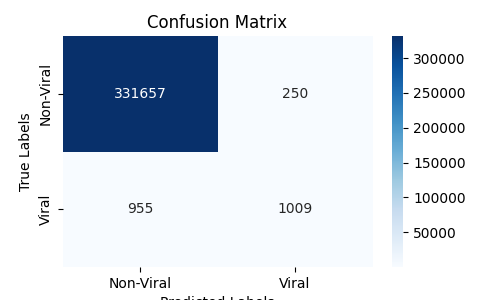

In [ ]:
%%spark

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_best_rf, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Viral', 'Viral'], yticklabels=['Non-Viral', 'Viral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

%matplot plt

Inferences:

1. **Optimized Parameters**: The grid search has found a more optimal combination of tree depth and number of estimators, which balances the bias-variance trade-off better than before.

2. **Reduced Overfitting**: With a reduced maximum depth, the model may be less prone to overfitting, despite a very high cross-validated F1 score.

3. **Generalization Ability**: A small number of estimators (12) prevent the model from becoming overly complex, allowing it to generalize better to unseen data.

These changes indicate that parameter tuning can have a significant impact on a model's performance, sometimes leading to substantial improvements in certain metrics like precision while maintaining or slightly adjusting others like recall.

# Part 6: Conclusion

## Main Takeaways

1. **Model Performance and Class Imbalance**: Across different models—from logistic regression to more complex neural networks and random forests—we consistently observed high overall accuracy. However, this was often misleading due to the underlying class imbalance between the Viral and Non-Viral classes.
2. **Improvements with Complex Models**: Advanced models, particularly the random forest with tuned hyperparameters, showed improvements in precision and F1 score, suggesting that ensemble methods and model complexity can better handle class imbalance and feature interactions.
3. **Challenges with Minority Class Detection**: Despite various model optimizations, detecting the minority Viral class remained a challenge, as evidenced by relatively lower recall rates. This highlights the difficulty in effectively predicting less frequent outcomes even with sophisticated models.

## Future Modifications

1. **Incorporating Additional Features**: Adding more features that could influence the classification, such as temporal or geo-spatial data, might improve the model’s ability to differentiate between classes.
2. **Alternative Ensemble Techniques**: Experimenting with different ensemble methods like boosting or stacking might provide improvements in handling class imbalances and enhancing model performance.
3. **Advanced Metric Evaluation**: Beyond accuracy, focusing on metrics like the area under the Precision-Recall curve (AUC-PR) for a more nuanced evaluation of model performance in imbalanced datasets.

## Overall Experience + Team Reflection

1. **Valuable Insights from Model Comparisons**: The project allowed for a detailed examination of how different models and settings perform on imbalanced data, providing deep insights into strengths and limitations of each approach.
2. **Iterative Learning and Adaptation**: Adjusting models in response to performance metrics was an iterative and enlightening process, showcasing the dynamic nature of data science.
3. **Challenges in Processing Large Datasets**: Incorporating processing the huge dataset on Apache Spark.
4. **Challenges in Model Tuning and Evaluation**: Navigating the complexities of model tuning, especially with imbalanced data, was challenging but incredibly educational, emphasizing the need for a robust understanding of both data and model dynamics.
5. **Appreciation for Collaborative Learning**: Collaborating on this project was not only a technical challenge but also a team-building experience, highlighting the importance of diverse perspectives and collective problem-solving in data science.

The journey from preprocessing data to tuning advanced models has underscored the iterative essence of data science, where each step builds on the previous and guides future strategies.